# Decorrelating the data and dimension reduction

Dimension reduction summarizes a dataset using its common occuring patterns. In this notebook, we'll learn about the most fundamental of dimension reduction techniques, "Principal Component Analysis" ("PCA"). PCA is often used before supervised learning to improve model performance and generalization. It can also be useful for unsupervised learning. For example, we'll employ a variant of PCA that will allow us to cluster Wikipedia articles by their content!

In [48]:
from sklearn.decomposition import PCA

from scipy.stats import pearsonr

import config
import utils
import numpy as np
from numpy.core import ndarray
import pandas as pd
from pandas.core.frame import Series, DataFrame
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, List, Any, Union
from collections import namedtuple

In [2]:
basedir: str = os.getcwd()

In [3]:
datapaths: Dict[str, str] = {k: utils.normabspath(basedir, v) for k, v in config.paths.items()}
datapaths.keys()

dict_keys(['seeds', 'seeds-width-vs-length', 'artists', 'scrobbler-small-sample', 'wikipedia-vectors', 'wikipedia-vocabulary', 'stocks', 'eurovision', 'wine'])

In [4]:
wine = pd.read_csv(datapaths['wine'])
wine

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1,Barolo,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,Barolo,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,Barolo,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,Barolo,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,Barolo,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,Barbera,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,Barbera,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,Barbera,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,Barbera,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [103]:
def scatter_axis(xs: Series, 
                 ys: Series,
                 class_labels: Series = None,
                 xlim: tuple = None, 
                 ylim: tuple = None, 
                 align_axis_zero: bool = False, 
                 save: str = None, 
                 name: str = None,
                 title: str = None,
                 xy: Tuple[float, float] = None,
                 annotate_corr: bool = True,
                 pca_components: ndarray = None):
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
        
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    if class_labels is not None:
        plt.scatter(xs, ys, edgecolor='k', c=class_labels)
    else:
        plt.scatter(xs, ys, edgecolor='k')
    plt.xlabel(xs.name, rotation=0)
    plt.ylabel(ys.name, rotation=0)
    
    if annotate_corr:
        if xy is None:
            xy = (xlim[1] - 1, ylim[1] - 1)
        
        r, _ = pearsonr(xs, ys)
        plt.annotate(f'Pearson r = {np.round(r * 100)}%', xy=xy)
    
    if title is not None:
        fig.suptitle(title, fontsize=15, fontweight='bold')
    
    if align_axis_zero:
        xcoord: float = 0.5
        ycoord: float = 0.5
        
        x_range = xlim[1] - xlim[0]
        y_range = ylim[1] - ylim[0]
        
        if xlim[0] <= 0 and xlim[1] >= 0:
            xcoord = (0 - xlim[0]) / x_range
        
        if ylim[0] <= 0 and ylim[1] >= 0:
            ycoord = (0 - ylim[0]) / y_range
    
        ax.xaxis.set_label_coords(1.07, xcoord)
        ax.yaxis.set_label_coords(ycoord, 1.04)
    
    if pca_components is not None:
        plt.quiver(np.zeros(pca_components.shape[1]),
                   np.zeros(pca_components.shape[1]),
                   pca_components[0, :],
                   pca_components[1, :],
                   angles='xy', 
                   scale_units='xy', 
                   scale=1,
                   color='red')
        
    if save:
        fig.savefig(f'out/plots/{name}.png', dpi=600, transparent=True)
    plt.show()

In [97]:
model = PCA()
pca_features: ndarray = model.fit_transform(wine[['od280', 'total_phenols']])

xs: ndarray = pca_features[:, 0]
ys: ndarray = pca_features[:, 1]

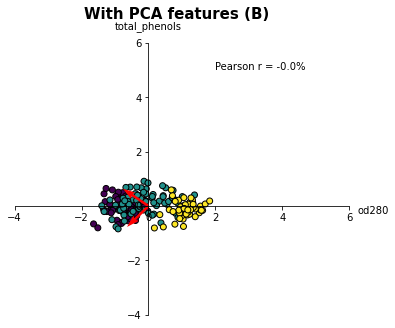

In [108]:
scatter_axis(pd.Series(xs, name='od280'), 
             pd.Series(ys, name='total_phenols'), 
             class_labels=wine['class_label'],
             xlim=(-4, 6), 
             ylim=(-4, 6), 
             align_axis_zero=True, 
             save=False, 
             name='total_phenols_vs_od280_pca',
             title='With PCA features (B)',
             xy=(2, 5),
             pca_components=model.components_)

In [55]:
correlation, pvalue = pearsonr(xs, ys)
correlation

-1.6653345369377348e-16

In [84]:
PCs = model.components_

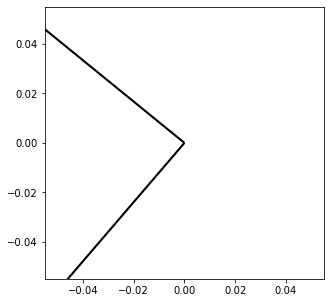

In [85]:
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)
plt.show()

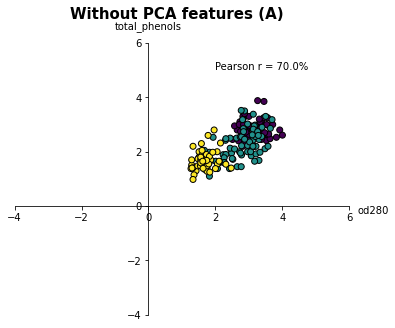

In [107]:
scatter_axis(wine['od280'], 
             wine['total_phenols'], 
             class_labels=wine['class_label'],
             xlim=(-4, 6), 
             ylim=(-4, 6), 
             align_axis_zero=True, 
             save=False, 
             name='total_phenols_vs_od280',
             title='Without PCA features (A)',
             xy=(2, 5))

In [96]:
correlation, pvalue = pearsonr(wine['od280'], wine['total_phenols'])
correlation

0.6999493647911862